In [130]:
pip install numpy matplotlib scikit-learn tensorflow astropy tensorflow_addons opencv-python torch scikit-optimize plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 40.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]2m1/2 [plotly]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
# additional imports for metrics and plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from astropy.visualization import ZScaleInterval


In [3]:
import torch

In [4]:

# Load training samples data
base_dir = "."
input_file = os.path.join(base_dir, "exromana_training_samples.npy")
data = np.load(input_file, allow_pickle=True).item()

tp_samples = data.get("TP", [])
fp_samples = data.get("FP", [])



In [5]:
tp_samples[0]["sample"].shape

(64, 64, 4)

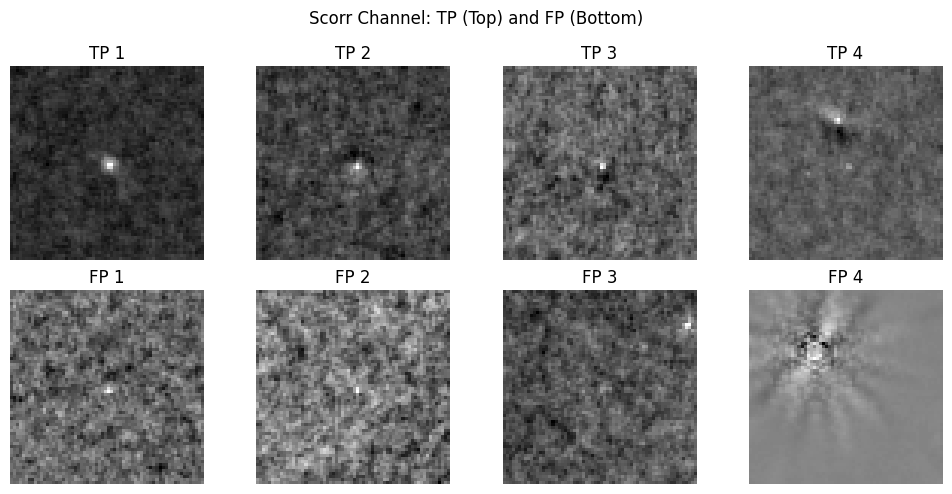

In [6]:

# Visualize 4 TP and 4 FP images
plt.figure(figsize=(10, 5))

# Plot 4 TP images
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(tp_samples[i]["sample"][..., 3], cmap="gray")
    plt.title("TP {}".format(i+1))
    plt.axis("off")

# Plot 4 FP images
for i in range(4):
    plt.subplot(2, 4, i + 5)
    plt.imshow(fp_samples[i]["sample"][..., 3], cmap="gray")
    plt.title("FP {}".format(i+1))
    plt.axis("off")

plt.suptitle("Scorr Channel: TP (Top) and FP (Bottom)")
plt.tight_layout()
plt.show()


In [7]:

# Extract the fourth layer (scorr channel) from sample["sample"] (64x64x4 array)
samples = []
labels = []
for sample in tp_samples:
    samples.append(sample["sample"][..., 3])
    labels.append(1)

for sample in fp_samples:
    samples.append(sample["sample"][..., 3])
    labels.append(0)

X = np.array(samples)
y = np.array(labels)

# Ensure images have a channel dimension (now grayscale images of the scorr layer)
if len(X.shape) == 3:  # shape (N, height, width)
    X = np.expand_dims(X, -1)

# Normalize the data using ZScale: for each sample compute limits and scale to [0,255]
zscale = ZScaleInterval()
X_z = np.empty_like(X, dtype=np.float32)
for i in range(X.shape[0]):
    # Remove channel dimension for zscale calculation
    img = X[i, ..., 0]
    vmin, vmax = zscale.get_limits(img)
    # Linear scaling to [0,255]
    scaled = (img - vmin) * (255.0 / (vmax - vmin))
    X_z[i, ..., 0] = np.clip(scaled, 0, 255)
X = X_z.astype(np.uint8)

print("After ZScale normalization - min:", np.min(X), "max:", np.max(X))

# Split data: first extract test set (15%), then split remaining into training and validation.
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
val_ratio = 0.15 / 0.85  # relative validation size from remaining data
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, random_state=42, stratify=y_temp)


After ZScale normalization - min: 0 max: 255


/var/folders/by/k_8nsxzs4p75xm0rpv7k951c0000gn/T/ipykernel_768/122674774.py:29: RuntimeWarning: invalid value encountered in cast
  X = X_z.astype(np.uint8)


In [8]:
X_train.shape

(3273, 64, 64, 1)

In [9]:
y_train.shape

(3273,)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Convert NumPy arrays to PyTorch tensors
def to_tensor_split(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, 1, 64, 64)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)         # (N, 1)
    return X_tensor, y_tensor

X_train_t, y_train_t = to_tensor_split(X_train, y_train)
X_val_t, y_val_t = to_tensor_split(X_val, y_val)
X_test_t, y_test_t = to_tensor_split(X_test, y_test)

# Optional: wrap in DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self,
                 in_channels=1,
                 conv_layers=3,
                 conv_kernel_size=3,
                 fc_layers=2,
                 fc_width=128,
                 normalization='BatchNorm',  # 'None', 'BatchNorm', 'Layernorm'
                 activation='ReLU',          # 'ReLU', 'LeakyReLU', 'GELU', 'Tanh'
                 dropout_rate=0.1):
        super().__init__()

        # ----------- Convolutional Layers -----------
        conv_blocks = []
        current_channels = in_channels
        out_channels = 16

        for i in range(conv_layers):
            conv_blocks.append(nn.Conv2d(current_channels, out_channels, kernel_size=conv_kernel_size, padding=conv_kernel_size // 2))
            conv_blocks.append(nn.ReLU())  # activation after conv
            conv_blocks.append(nn.MaxPool2d(2))  # halve spatial size
            current_channels = out_channels
            out_channels *= 2  # double output channels at each layer

        self.conv_net = nn.Sequential(*conv_blocks)

        # Calculate flattened size after convolutions (from 64x64 input)
        spatial_dim = 64 // (2 ** conv_layers)
        self.flat_dim = current_channels * spatial_dim * spatial_dim

        # ----------- Fully Connected Layers -----------
        fc_blocks = []
        input_dim = self.flat_dim

        norm_layer = {
            'BatchNorm': lambda dim: nn.BatchNorm1d(dim),
            'Layernorm': lambda dim: nn.LayerNorm(dim),
            'None': lambda dim: nn.Identity()
        }[normalization]

        act_layer = {
            'ReLU': nn.ReLU(),
            'LeakyReLU': nn.LeakyReLU(),
            'GELU': nn.GELU(),
            'Tanh': nn.Tanh()
        }[activation]

        for i in range(fc_layers - 1):  # exclude final FC layer
            fc_blocks.append(nn.Linear(input_dim, fc_width))
            fc_blocks.append(norm_layer(fc_width))
            fc_blocks.append(act_layer)
            fc_blocks.append(nn.Dropout(dropout_rate))
            input_dim = fc_width

        # Final FC layer (no norm, no activation, no dropout)
        fc_blocks.append(nn.Linear(input_dim, 1))

        self.fc_net = nn.Sequential(*fc_blocks)

    def forward(self, x):
        x = self.conv_net(x)         # Conv part
        x = x.view(x.size(0), -1)    # Flatten
        x = self.fc_net(x)           # FC part
        return x  # raw logits


In [12]:
model = Model(
    conv_layers=3,
    conv_kernel_size=5,
    fc_layers=3,
    fc_width=128,
    normalization='Layernorm',
    activation='GELU',
    dropout_rate=0.2
)
print(model)


Model(
  (conv_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_net): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in

In [13]:
y_flat = y_train_t.squeeze()

# Indices of each class
idx_0 = (y_flat == 0).nonzero(as_tuple=True)[0]
idx_1 = (y_flat == 1).nonzero(as_tuple=True)[0]

# Choose 1091 samples from each class
balanced_idx_0 = idx_0[:1091]
balanced_idx_1 = idx_1[:1091]

# Concatenate and shuffle
balanced_indices = torch.cat([balanced_idx_0, balanced_idx_1])
balanced_indices = balanced_indices[torch.randperm(len(balanced_indices))]

# Subset X and y
X_train_balanced = X_train_t[balanced_indices]
y_train_balanced = y_train_t[balanced_indices]

In [14]:
X_train_balanced.shape

torch.Size([2182, 1, 64, 64])

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from copy import deepcopy
import time

def train_model(conv_layers=3, conv_kernel_size=3,
                fc_layers=2, fc_width=128,
                normalization='BatchNorm', activation='ReLU', dropout_rate=0.1,
                lr=1e-3, weight_decay=1e-4, batch_size=64,
                t_max=50, early_stop_patience=5):


    # casting variables

    # int_fields = ['conv_layers', 'conv_kernel_size', 'fc_layers', 'fc_width',
    #               'batch_size', 't_max', 'early_stop_patience']
    # float_fields = ['dropout_rate', 'lr', 'weight_decay']

    # for name in int_fields:
    #     val = locals()[name]
    #     if not isinstance(val, int):
    #         locals()[name] = int(val)

    # for name in float_fields:
    #     val = locals()[name]
    #     if not isinstance(val, float):
    #         locals()[name] = float(val)

    # # Rebind variables from updated locals
    # conv_layers = locals()['conv_layers']
    # conv_kernel_size = locals()['conv_kernel_size']
    # fc_layers = locals()['fc_layers']
    # fc_width = locals()['fc_width']
    # batch_size = locals()['batch_size']
    # t_max = locals()['t_max']
    # early_stop_patience = locals()['early_stop_patience']
    # dropout_rate = locals()['dropout_rate']
    # lr = locals()['lr']
    # weight_decay = locals()['weight_decay']

    if not isinstance(batch_size, int):
        batch_size = int(batch_size)

    print("batch type: ", type(batch_size))



    model = Model(conv_layers=conv_layers,
                  conv_kernel_size=conv_kernel_size,
                  fc_layers=fc_layers,
                  fc_width=fc_width,
                  normalization=normalization,
                  activation=activation,
                  dropout_rate=dropout_rate)
    
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

    print('created model')

    device = next(model.parameters()).device
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size)

    print('created dataset splits')

    pos_weight = torch.tensor([2.0]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max)

    best_model = None
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience_counter = 0

    print('training')

    start_time = time.time()

    # Arrays to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(t_max):
        elapsed = time.time() - start_time
        if elapsed > 500:
            print(f"Stopping early due to time limit: {elapsed:.2f} seconds elapsed.")
            break

        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for xb, yb in train_loader:
            if xb.shape[0] <= 1:
                continue
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)
            preds = (torch.sigmoid(output) > 0.5).float()
            correct_train += (preds == yb).sum().item()
            total_train += yb.size(0)

        train_loss /= total_train
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        scheduler.step()

        model.eval()
        val_loss = 0.0
        logits_list = []
        labels_list = []

        with torch.no_grad():
            for xb, yb in val_loader:
                if xb.shape[0] <= 1: 
                    continue
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                val_loss += criterion(output, yb).item() * xb.size(0)
                logits_list.append(output.cpu())
                labels_list.append(yb.cpu())

        logits_all = torch.cat(logits_list).squeeze()
        labels_all = torch.cat(labels_list).squeeze()

        N_val = logits_all.shape[0]
        k = int(N_val * (1 / 3))
        threshold = torch.topk(logits_all, k).values.min()
        preds = (logits_all >= threshold).float()

        val_loss /= N_val
        correct_val = (preds == labels_all).sum().item()
        val_acc = correct_val / N_val
        percent_pred_1 = 100.0 * preds.sum().item() / N_val

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Pred_1: {percent_pred_1:.2f}% | "
              f"LR: {scheduler.get_last_lr()[0]:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model = deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model)
    total_time = time.time() - start_time
    return model, best_val_acc, total_time, train_losses, train_accuracies, val_losses, val_accuracies


In [16]:
# model, best_val_acc, total_time, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
#     conv_layers=4,
#     conv_kernel_size=5,
#     fc_layers=3,
#     fc_width=256,
#     normalization='Layernorm',
#     activation='GELU',
#     dropout_rate=0.2,
#     lr=1e-2,
#     weight_decay=1e-3,
#     batch_size=16,
#     t_max=25,
#     early_stop_patience=3,
# )


In [18]:
param_space = {
    'conv_layers': [1, 2, 3, 4],
    'conv_kernel_size': [3, 5, 7],
    'fc_layers': [1, 2, 3, 4, 5],
    'fc_width': [32, 64, 128, 256],
    'normalization': ['None', 'BatchNorm', 'Layernorm'],
    'activation': ['ReLU', 'LeakyReLU', 'GELU', 'Tanh'],
    'dropout_rate': [0, 0.05, 0.1, 0.2, 0.3],
    'lr': [1e-1, 1e-2, 1e-3, 1e-4],
    'weight_decay': [1e-2, 1e-3, 1e-4, 1e-5],
    'batch_size': [4, 16, 64, 256],
    't_max': [10, 25, 50, 100],
    'early_stop_patience': [3, 5, 10]
}

# Random Search

In [21]:
import random
import itertools
import random
import os
import json


def random_sample(params):
    return {key: random.choice(values) for key, values in params.items()}

# Track best model and score
best_model = None
best_val_acc = 0.0
best_config = None

# Directory for results
base_dir = "random_search"
os.makedirs(base_dir, exist_ok=True)

# Set number of trials
n_trials = 10

for trial in range(90, 101):
    config = random_sample(param_space)

    print(f"\n=== Trial {trial + 1} ===")
    for k, v in config.items():
        print(f"{k}: {v}")

    # Train model with the current config
    model, val_acc, total_time, train_losses, train_accuracies, val_losses, val_accuracies = train_model(**config)

    print(f"Validation Accuracy: {val_acc:.4f}")

    # Save trial results
    trial_dir = os.path.join(base_dir, f"trial_{trial + 1}")
    os.makedirs(trial_dir, exist_ok=True)

    # Save config
    with open(os.path.join(trial_dir, "config.json"), "w") as f:
        json.dump(config, f, indent=2)

    # Save results
    results = {
        "val_acc": val_acc,
        "total_time": total_time,
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies
    }
    with open(os.path.join(trial_dir, "results.json"), "w") as f:
        json.dump(results, f, indent=2)

    # Update best model tracking
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_config = config

# Summary
print("\n=== Best Trial Summary ===")
for k, v in best_config.items():
    print(f"{k}: {v}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")



=== Trial 91 ===
conv_layers: 1
conv_kernel_size: 7
fc_layers: 1
fc_width: 64
normalization: None
activation: GELU
dropout_rate: 0.1
lr: 0.001
weight_decay: 0.001
batch_size: 64
t_max: 10
early_stop_patience: 5
batch type:  <class 'int'>
created model
created dataset splits
training
Epoch  1 | Train Loss: 47.8055 | Train Acc: 0.5515 | Val Loss: 1.5886 | Val Acc: 0.6353 | Pred_1: 33.33% | LR: 0.000976
Epoch  2 | Train Loss: 1.1646 | Train Acc: 0.6621 | Val Loss: 1.3410 | Val Acc: 0.6182 | Pred_1: 33.33% | LR: 0.000905
Epoch  3 | Train Loss: 0.8184 | Train Acc: 0.6868 | Val Loss: 1.3024 | Val Acc: 0.6182 | Pred_1: 33.33% | LR: 0.000794
Epoch  4 | Train Loss: 0.6718 | Train Acc: 0.7259 | Val Loss: 1.2987 | Val Acc: 0.6296 | Pred_1: 33.33% | LR: 0.000655
Epoch  5 | Train Loss: 0.5768 | Train Acc: 0.7794 | Val Loss: 1.4594 | Val Acc: 0.6353 | Pred_1: 33.33% | LR: 0.000500
Epoch  6 | Train Loss: 0.4973 | Train Acc: 0.8185 | Val Loss: 1.3805 | Val Acc: 0.6382 | Pred_1: 33.33% | LR: 0.000345


# Ablation Search

In [35]:
import os
import json
import random
from collections import defaultdict

# Max trials cap
max_trials = 100

# Choose a fixed random baseline configuration
baseline_config = {k: random.choice(v) for k, v in param_space.items()}

print("=== Baseline Configuration ===")
for k, v in baseline_config.items():
    print(f"{k}: {v}")

# Directory to save ablation search results
base_dir = "ablation_search"
os.makedirs(base_dir, exist_ok=True)

# Store best results
results = []
trial_counter = 1

# Loop over each hyperparameter
for hyperparam, values in param_space.items():
    print(f"\n--- Varying '{hyperparam}' ---")

    for val in values:
        if trial_counter > max_trials:
            print(f"\nReached trial cap of {max_trials}. Ending search.")
            break

        config = baseline_config.copy()
        config[hyperparam] = val

        print(f"\n=== Trial {trial_counter} | {hyperparam} = {val} ===")
        for k, v in config.items():
            print(f"{k}: {v}")

        # Train the model
        model, val_acc, total_time, train_losses, train_accuracies, val_losses, val_accuracies = train_model(**config)

        print(f"Validation Accuracy: {val_acc:.4f}")

        # Save to directory
        trial_dir = os.path.join(base_dir, f"trial_{trial_counter}")
        os.makedirs(trial_dir, exist_ok=True)

        with open(os.path.join(trial_dir, "config.json"), "w") as f:
            json.dump(config, f, indent=2)

        results_dict = {
            "val_acc": val_acc,
            "total_time": total_time,
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies
        }
        with open(os.path.join(trial_dir, "results.json"), "w") as f:
            json.dump(results_dict, f, indent=2)

        results.append((hyperparam, val, val_acc))
        trial_counter += 1

    # Stop outer loop too if limit reached
    if trial_counter > max_trials:
        break

# Sort and report best values per hyperparameter
best_per_param = defaultdict(lambda: (None, 0.0))  # {param: (value, val_acc)}

for param, val, acc in results:
    if acc > best_per_param[param][1]:
        best_per_param[param] = (val, acc)

print("\n=== Best Values Per Hyperparameter ===")
for param, (val, acc) in best_per_param.items():
    print(f"{param}: {val} (Val Acc: {acc:.4f})")


=== Baseline Configuration ===
conv_layers: 3
conv_kernel_size: 5
fc_layers: 5
fc_width: 32
normalization: BatchNorm
activation: LeakyReLU
dropout_rate: 0.2
lr: 0.01
weight_decay: 1e-05
batch_size: 256
t_max: 50
early_stop_patience: 5

--- Varying 'conv_layers' ---

=== Trial 1 | conv_layers = 1 ===
conv_layers: 1
conv_kernel_size: 5
fc_layers: 5
fc_width: 32
normalization: BatchNorm
activation: LeakyReLU
dropout_rate: 0.2
lr: 0.01
weight_decay: 1e-05
batch_size: 256
t_max: 50
early_stop_patience: 5
batch type:  <class 'int'>
created model
created dataset splits
training
Epoch  1 | Train Loss: 0.8416 | Train Acc: 0.5973 | Val Loss: 0.9125 | Val Acc: 0.6467 | Pred_1: 33.33% | LR: 0.009990
Epoch  2 | Train Loss: 0.7655 | Train Acc: 0.6352 | Val Loss: 0.9524 | Val Acc: 0.5983 | Pred_1: 33.33% | LR: 0.009961
Epoch  3 | Train Loss: 0.7211 | Train Acc: 0.6621 | Val Loss: 4.4351 | Val Acc: 0.6353 | Pred_1: 33.33% | LR: 0.009911
Epoch  4 | Train Loss: 0.6733 | Train Acc: 0.6896 | Val Loss: 0.8

# Genetic Algorithm

In [30]:
import os
import json
import random
from copy import deepcopy

def genetic_search(param_space, max_trials=100, population_size=10, elite_size=2, mutation_rate=0.1, generations=10):
    assert population_size * generations >= max_trials, "Too many generations/trials requested."

    trial_counter = 1
    base_dir = "genetic_search"
    os.makedirs(base_dir, exist_ok=True)
    results = []

    def random_individual():
        return {key: random.choice(values) for key, values in param_space.items()}

    def mutate(ind):
        ind = deepcopy(ind)
        key = random.choice(list(param_space.keys()))
        ind[key] = random.choice(param_space[key])
        return ind

    def crossover(parent1, parent2):
        child = {}
        for k in param_space.keys():
            child[k] = random.choice([parent1[k], parent2[k]])
        return child

    # Initialize population
    population = [random_individual() for _ in range(population_size)]

    for gen in range(generations):
        print(f"\n=== Generation {gen + 1} ===")
        fitness_scores = []

        for individual in population:
            if trial_counter > max_trials:
                break

            print(f"\n--- Trial {trial_counter} ---")
            for k, v in individual.items():
                print(f"{k}: {v}")

            # Train and evaluate
            model, val_acc, total_time, train_losses, train_accuracies, val_losses, val_accuracies = train_model(**individual)

            # Save results
            trial_dir = os.path.join(base_dir, f"trial_{trial_counter}")
            os.makedirs(trial_dir, exist_ok=True)

            with open(os.path.join(trial_dir, "config.json"), "w") as f:
                json.dump(individual, f, indent=2)

            results_dict = {
                "val_acc": val_acc,
                "total_time": total_time,
                "train_losses": train_losses,
                "train_accuracies": train_accuracies,
                "val_losses": val_losses,
                "val_accuracies": val_accuracies
            }
            with open(os.path.join(trial_dir, "results.json"), "w") as f:
                json.dump(results_dict, f, indent=2)

            fitness_scores.append((val_acc, individual))
            results.append((val_acc, individual))
            trial_counter += 1

        # Select top performers
        fitness_scores.sort(reverse=True, key=lambda x: x[0])
        elites = [ind for _, ind in fitness_scores[:elite_size]]

        # Generate next population
        new_population = elites[:]
        while len(new_population) < population_size:
            parent1, parent2 = random.choices(elites, k=2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                child = mutate(child)
            new_population.append(child)

        population = new_population

        if trial_counter > max_trials:
            break

    # Report best result
    best_acc, best_config = max(results, key=lambda x: x[0])
    print("\n=== Best Hyperparameter Set ===")
    for k, v in best_config.items():
        print(f"{k}: {v}")
    print(f"Best Validation Accuracy: {best_acc:.4f}")

    return best_config, best_acc

best_config, best_acc = genetic_search(param_space, max_trials=100, population_size=10, generations=10)




=== Generation 1 ===

--- Trial 1 ---
conv_layers: 1
conv_kernel_size: 5
fc_layers: 4
fc_width: 256
normalization: BatchNorm
activation: ReLU
dropout_rate: 0.3
lr: 0.1
weight_decay: 0.0001
batch_size: 16
t_max: 100
early_stop_patience: 3
batch type:  <class 'int'>
created model
created dataset splits
training
Epoch  1 | Train Loss: 0.9864 | Train Acc: 0.5555 | Val Loss: 0.8602 | Val Acc: 0.6524 | Pred_1: 33.33% | LR: 0.099975
Epoch  2 | Train Loss: 0.8868 | Train Acc: 0.5509 | Val Loss: 1.2861 | Val Acc: 0.6410 | Pred_1: 33.33% | LR: 0.099901
Epoch  3 | Train Loss: 0.8574 | Train Acc: 0.5729 | Val Loss: 0.8900 | Val Acc: 0.5114 | Pred_1: 79.63% | LR: 0.099778
Epoch  4 | Train Loss: 0.8712 | Train Acc: 0.5570 | Val Loss: 0.9172 | Val Acc: 0.5812 | Pred_1: 67.52% | LR: 0.099606
Early stopping at epoch 4

--- Trial 2 ---
conv_layers: 4
conv_kernel_size: 3
fc_layers: 2
fc_width: 32
normalization: None
activation: ReLU
dropout_rate: 0
lr: 0.0001
weight_decay: 0.01
batch_size: 4
t_max: 100


# Bayesian Search

In [19]:
from skopt import Optimizer
from skopt.space import Categorical
import os
import json

def bayesian_search(param_space, max_trials=100):
    base_dir = "bayesian_search"
    os.makedirs(base_dir, exist_ok=True)

    trial_counter = 34
    results = []

    # Use only Categorical dimensions to restrict values to the provided lists
    skopt_space = [Categorical(param_space[k], name=k) for k in param_space]
    param_keys = list(param_space.keys())

    optimizer = Optimizer(skopt_space, base_estimator="GP", acq_func="EI", random_state=42)

    best_acc = 0.0
    best_config = None

    for i in range(max_trials):

        # Suggest next config
        next_params = optimizer.ask()
        config = dict(zip(param_keys, next_params))

        print(f"\n--- Trial {trial_counter} ---")
        for k, v in config.items():
            print(f"{k}: {v}")

        print(config)

        # Train and evaluate
        model, val_acc, total_time, train_losses, train_accuracies, val_losses, val_accuracies = train_model(**config)

        # Save trial results
        trial_dir = os.path.join(base_dir, f"trial_{trial_counter}")
        os.makedirs(trial_dir, exist_ok=True)

        config = {
            k: v.item() if hasattr(v, 'item') else v
            for k, v in config.items()
        }

        with open(os.path.join(trial_dir, "config.json"), "w") as f:
            json.dump(config, f, indent=2)

        results_dict = {
            "val_acc": val_acc,
            "total_time": total_time,
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies
        }

        
        with open(os.path.join(trial_dir, "results.json"), "w") as f:
            json.dump(results_dict, f, indent=2)

        # Update optimizer and best config
        optimizer.tell(next_params, -val_acc)  # maximize => minimize -val_acc

        if val_acc > best_acc:
            best_acc = val_acc
            best_config = config

        trial_counter += 1

    print("\n=== Best Hyperparameter Set ===")
    for k, v in best_config.items():
        print(f"{k}: {v}")
    print(f"Best Validation Accuracy: {best_acc:.4f}")

    return best_config, best_acc

best_config, best_acc = bayesian_search(param_space, max_trials=100)



--- Trial 34 ---
conv_layers: 4
conv_kernel_size: 3
fc_layers: 4
fc_width: 128
normalization: BatchNorm
activation: ReLU
dropout_rate: 0.1
lr: 0.01
weight_decay: 0.01
batch_size: 64
t_max: 10
early_stop_patience: 10
{'conv_layers': 4, 'conv_kernel_size': 3, 'fc_layers': 4, 'fc_width': 128, 'normalization': 'BatchNorm', 'activation': 'ReLU', 'dropout_rate': 0.1, 'lr': 0.01, 'weight_decay': 0.01, 'batch_size': 64, 't_max': 10, 'early_stop_patience': 10}
batch type:  <class 'int'>
created model
created dataset splits
training
Epoch  1 | Train Loss: 0.8009 | Train Acc: 0.6242 | Val Loss: 1.1357 | Val Acc: 0.6724 | Pred_1: 33.33% | LR: 0.009755
Epoch  2 | Train Loss: 0.7694 | Train Acc: 0.6355 | Val Loss: 0.9647 | Val Acc: 0.6752 | Pred_1: 33.33% | LR: 0.009045
Epoch  3 | Train Loss: 0.7722 | Train Acc: 0.6334 | Val Loss: 0.8001 | Val Acc: 0.6809 | Pred_1: 33.33% | LR: 0.007939
Epoch  4 | Train Loss: 0.7657 | Train Acc: 0.6309 | Val Loss: 0.7988 | Val Acc: 0.6011 | Pred_1: 33.33% | LR: 0.0

# Plotting

In [23]:
import os
import json
import matplotlib.pyplot as plt

def plot_val_metrics_time_series(base_dir):
    trial_dirs = sorted([
        d for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("trial_")
    ], key=lambda x: int(x.split("_")[1]))

    val_accs = []
    max_accs = []
    val_losses = []
    min_losses = []

    for trial in trial_dirs:
        result_path = os.path.join(base_dir, trial, "results.json")
        if not os.path.exists(result_path):
            continue
        
        with open(result_path, "r") as f:
            data = json.load(f)
            val_acc = data.get("val_acc")
            val_loss_series = data.get("val_losses")

            if val_acc is not None and val_loss_series:
                val_accs.append(val_acc)
                max_accs.append(max(val_accs))

                last_val_loss = val_loss_series[-1]
                val_losses.append(last_val_loss)
                min_losses.append(min(val_losses))

    # --- Plotting ---
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Val Accuracy
    axs[0, 0].plot(val_accs, marker='o')
    axs[0, 0].set_title("Validation Accuracy per Trial")
    axs[0, 0].set_xlabel("Trial")
    axs[0, 0].set_ylabel("Val Accuracy")
    axs[0, 0].grid(True)

    # Best Val Accuracy
    axs[0, 1].plot(max_accs, marker='o', color='green')
    axs[0, 1].set_title("Best-so-far Validation Accuracy")
    axs[0, 1].set_xlabel("Trial")
    axs[0, 1].set_ylabel("Best Val Accuracy")
    axs[0, 1].grid(True)

    # Val Loss
    axs[1, 0].plot(val_losses, marker='o', color='orange')
    axs[1, 0].set_title("Validation Loss per Trial")
    axs[1, 0].set_xlabel("Trial")
    axs[1, 0].set_ylabel("Val Loss")
    axs[1, 0].grid(True)

    # Best Val Loss
    axs[1, 1].plot(min_losses, marker='o', color='red')
    axs[1, 1].set_title("Best-so-far (lowest) Validation Loss")
    axs[1, 1].set_xlabel("Trial")
    axs[1, 1].set_ylabel("Best Val Loss So Far")
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()


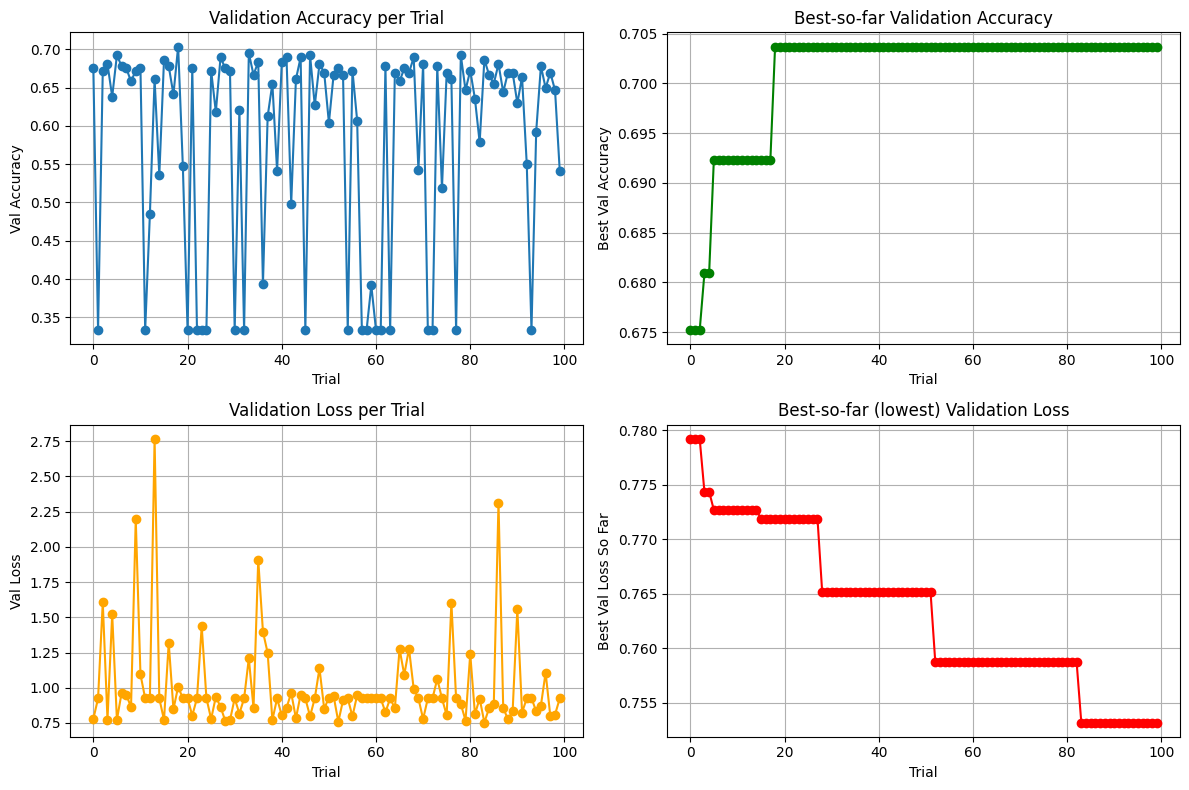

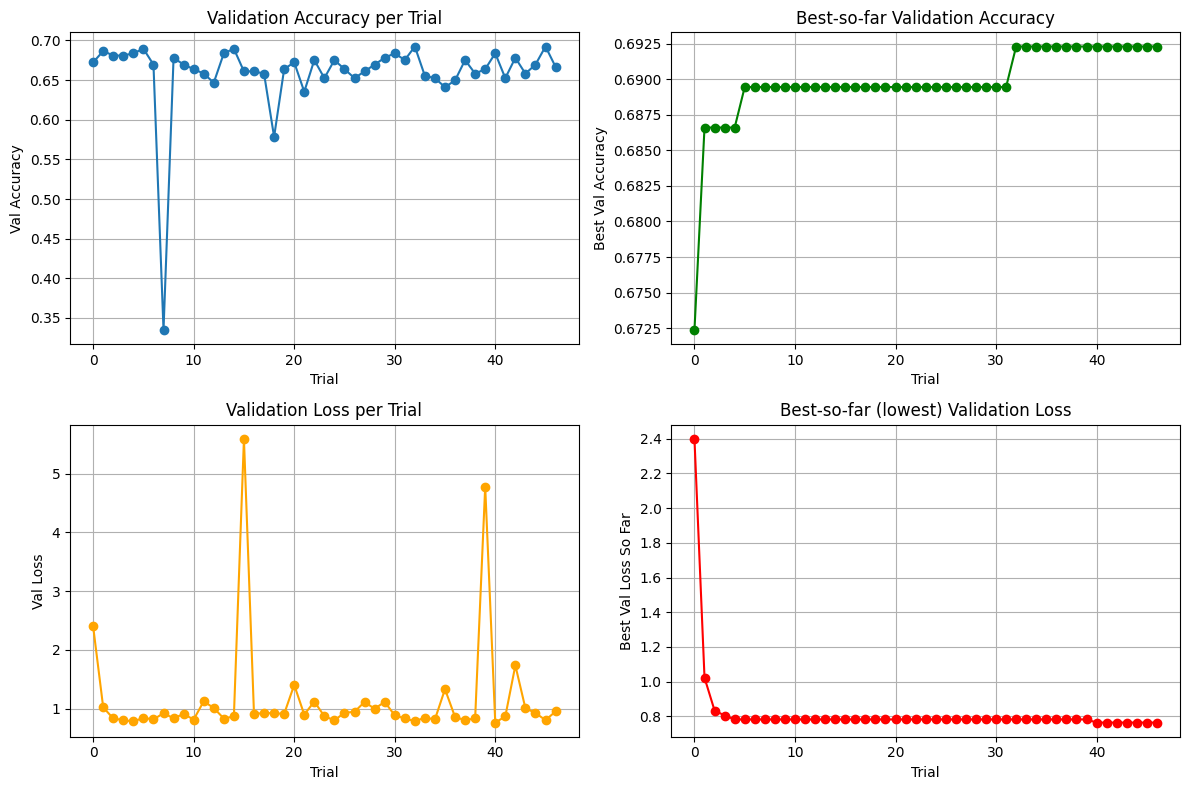

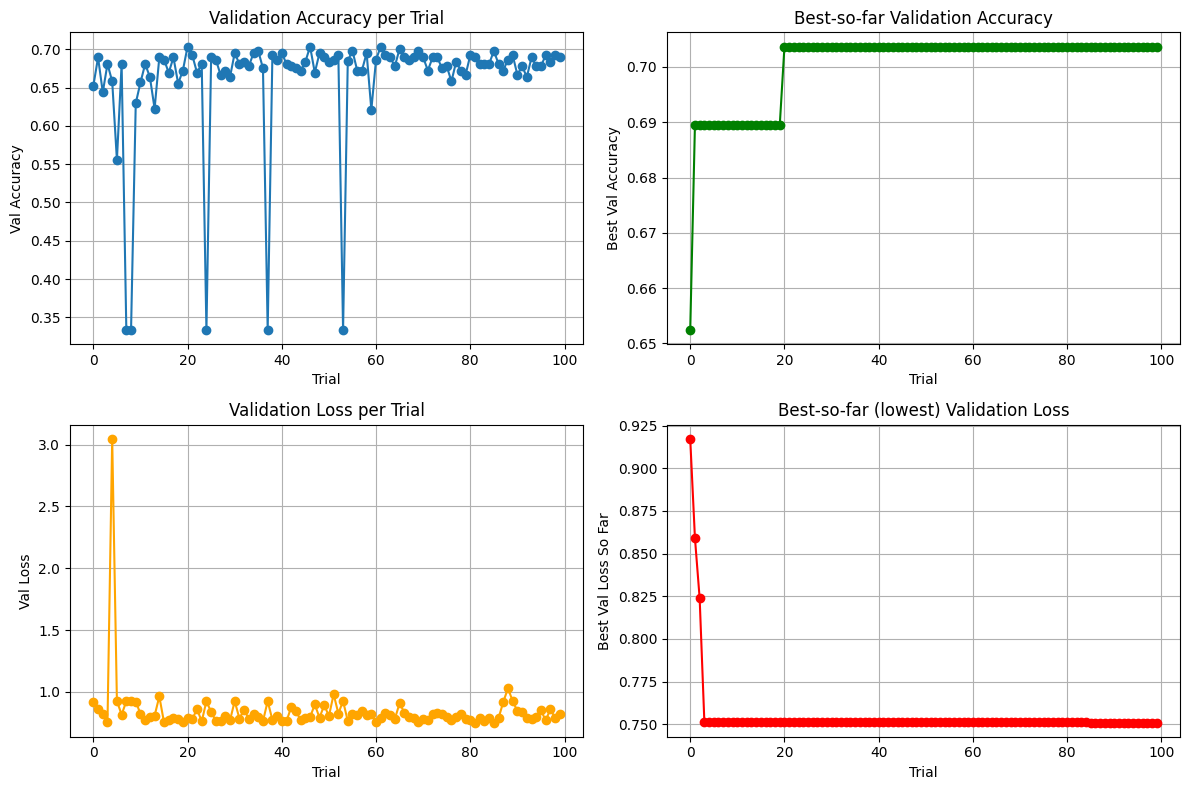

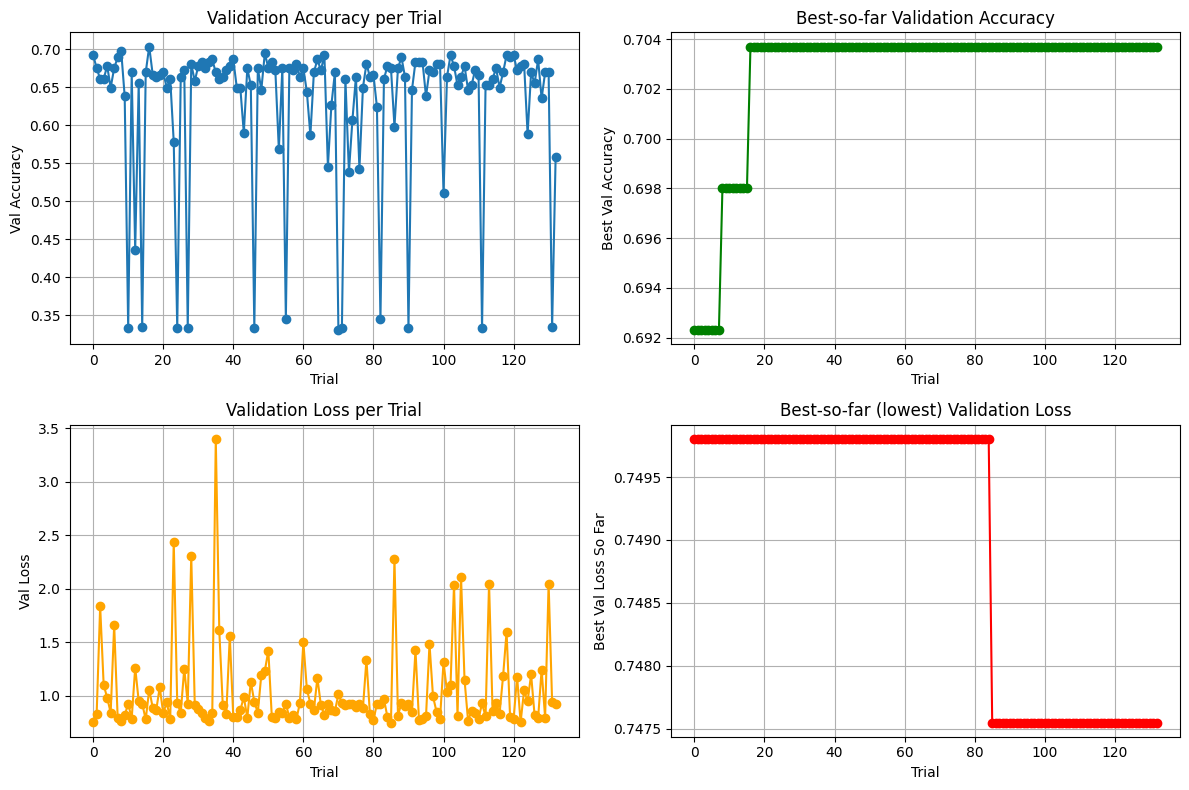

In [25]:
plot_val_metrics_time_series("random_search")
plot_val_metrics_time_series("ablation_search")
plot_val_metrics_time_series("genetic_search")
plot_val_metrics_time_series("bayesian_search")

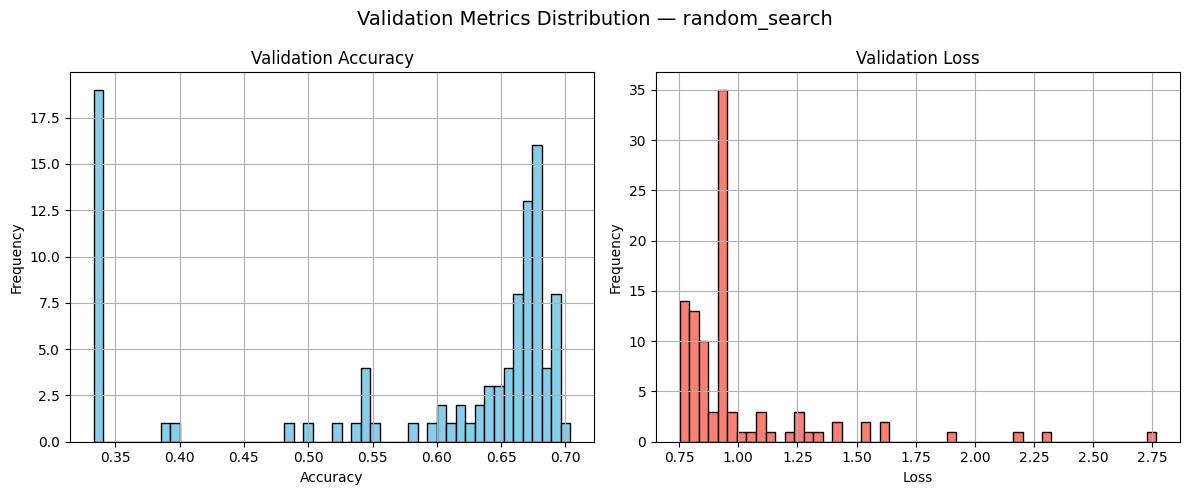

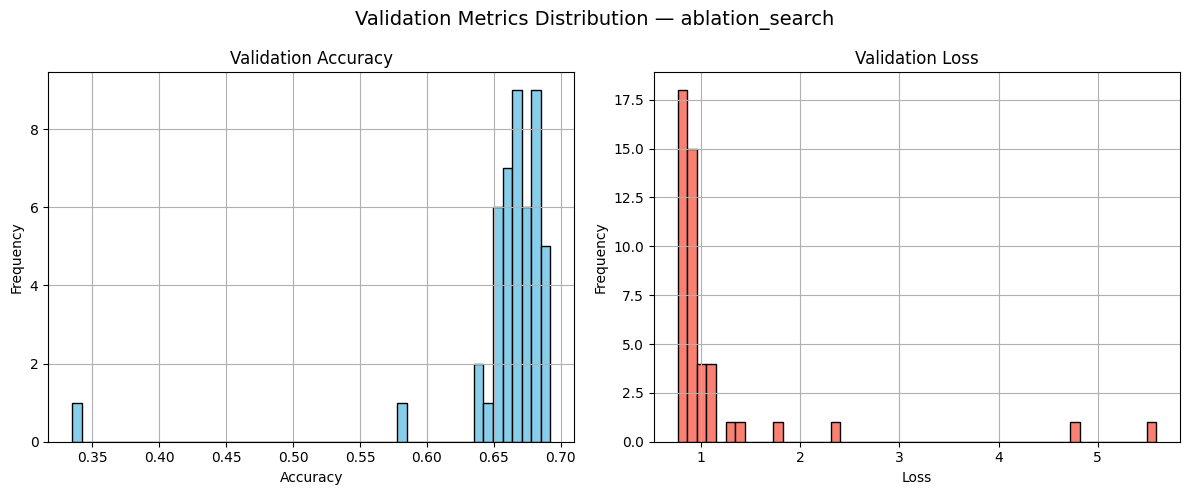

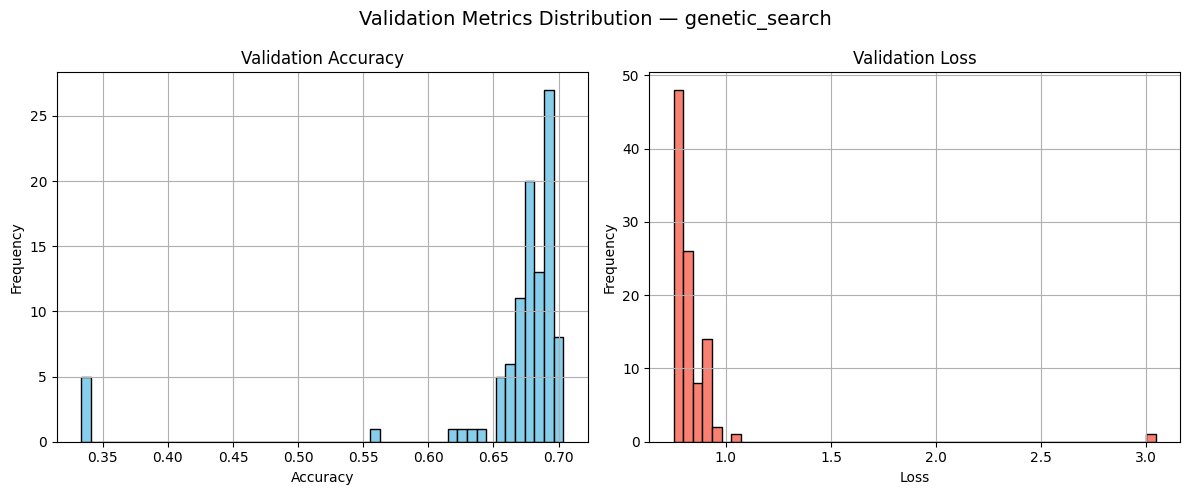

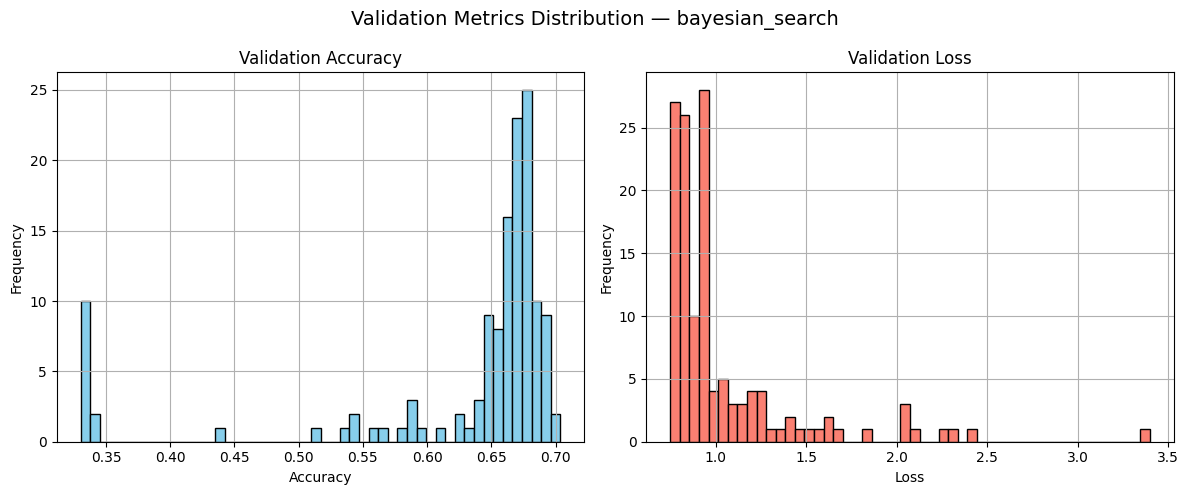

In [30]:
import os
import json
import matplotlib.pyplot as plt

def plot_val_metrics_histograms(base_dir):
    trial_dirs = sorted([
        d for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("trial_")
    ], key=lambda x: int(x.split("_")[1]))

    val_accs = []
    val_losses = []

    for trial in trial_dirs:
        result_path = os.path.join(base_dir, trial, "results.json")
        if not os.path.exists(result_path):
            continue

        with open(result_path, "r") as f:
            data = json.load(f)
            val_acc = data.get("val_acc")
            val_loss_series = data.get("val_losses")

            if val_acc is not None:
                val_accs.append(val_acc)
            if val_loss_series:
                val_losses.append(val_loss_series[-1])  # last epoch loss

    # Plot histograms
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Validation Metrics Distribution — {base_dir}", fontsize=14)

    axs[0].hist(val_accs, bins=50, color='skyblue', edgecolor='black')
    axs[0].set_title("Validation Accuracy")
    axs[0].set_xlabel("Accuracy")
    axs[0].set_ylabel("Frequency")
    axs[0].grid(True)

    axs[1].hist(val_losses, bins=50, color='salmon', edgecolor='black')
    axs[1].set_title("Validation Loss")
    axs[1].set_xlabel("Loss")
    axs[1].set_ylabel("Frequency")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Run for each optimization strategy
for method in ["random_search", "ablation_search", "genetic_search", "bayesian_search"]:
    plot_val_metrics_histograms(method)


In [26]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_all_epoch_curves(base_dir):
    trial_dirs = sorted([
        d for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("trial_")
    ], key=lambda x: int(x.split("_")[1]))

    all_val_accs = []
    all_val_losses = []
    all_train_accs = []
    all_train_losses = []

    for trial in trial_dirs:
        result_path = os.path.join(base_dir, trial, "results.json")
        if not os.path.exists(result_path):
            continue

        with open(result_path, "r") as f:
            data = json.load(f)
            all_val_accs.append(data.get("val_accuracies", []))
            all_val_losses.append(data.get("val_losses", []))
            all_train_accs.append(data.get("train_accuracies", []))
            all_train_losses.append(data.get("train_losses", []))

    n_trials = len(all_train_losses)
    colors = plt.cm.viridis(np.linspace(0, 1, n_trials))

    # --- Plotting ---
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    # Training Loss
    for i, loss in enumerate(all_train_losses):
        axs[0, 0].plot(loss, alpha=0.8, color=colors[i])
    axs[0, 0].set_title("Training Loss per Epoch")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Train Loss")
    axs[0, 0].set_ylim(0.5, 1.5)
    axs[0, 0].grid(True)

    # Training Accuracy
    for i, acc in enumerate(all_train_accs):
        axs[0, 1].plot(acc, alpha=0.8, color=colors[i])
    axs[0, 1].set_title("Training Accuracy per Epoch")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Train Accuracy")
    axs[0, 1].grid(True)

    # Validation Loss
    for i, loss in enumerate(all_val_losses):
        axs[1, 0].plot(loss, alpha=0.8, color=colors[i])
    axs[1, 0].set_title("Validation Loss per Epoch")
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Val Loss")
    axs[1, 0].set_ylim(0.5, 1.5)
    axs[1, 0].grid(True)

    # Validation Accuracy
    for i, acc in enumerate(all_val_accs):
        axs[1, 1].plot(acc, alpha=0.8, color=colors[i])
    axs[1, 1].set_title("Validation Accuracy per Epoch")
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Val Accuracy")
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()


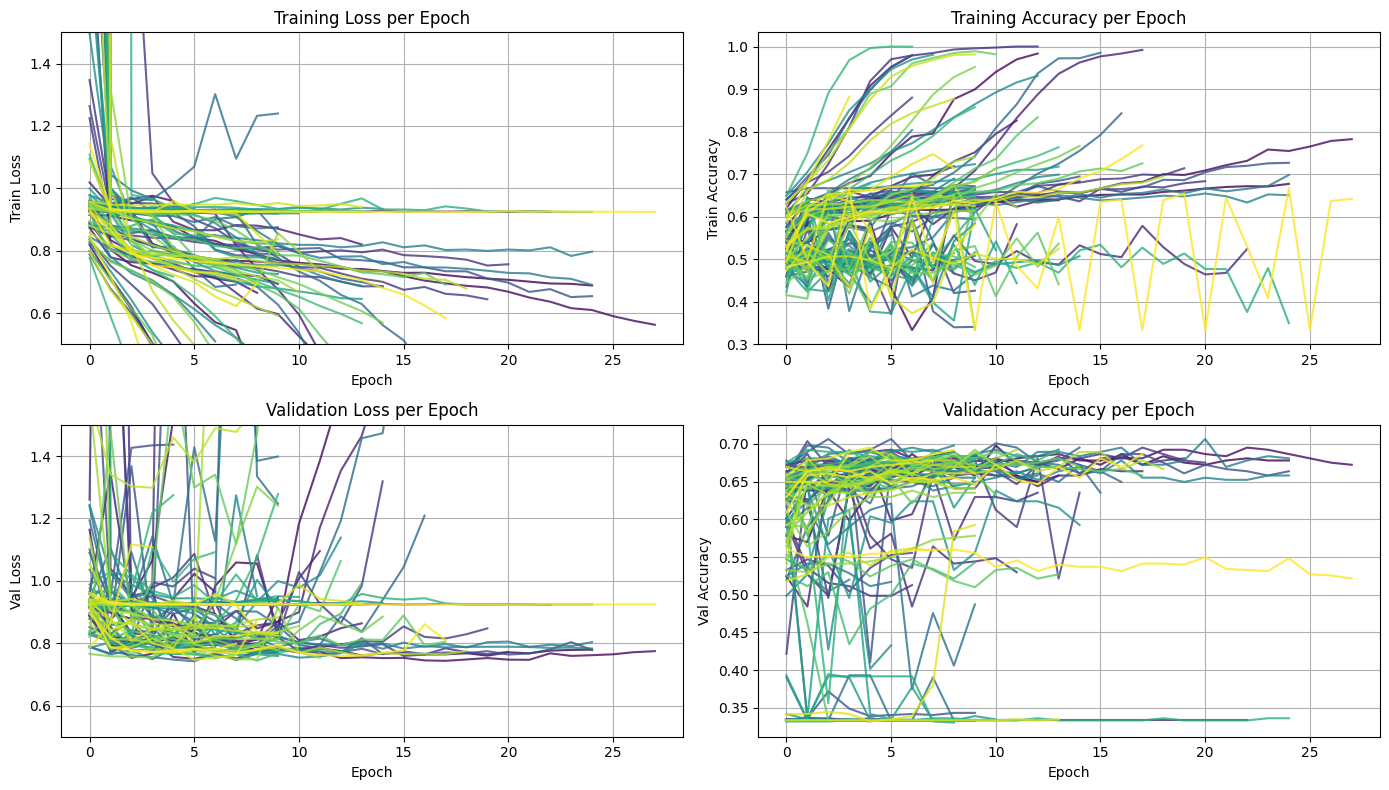

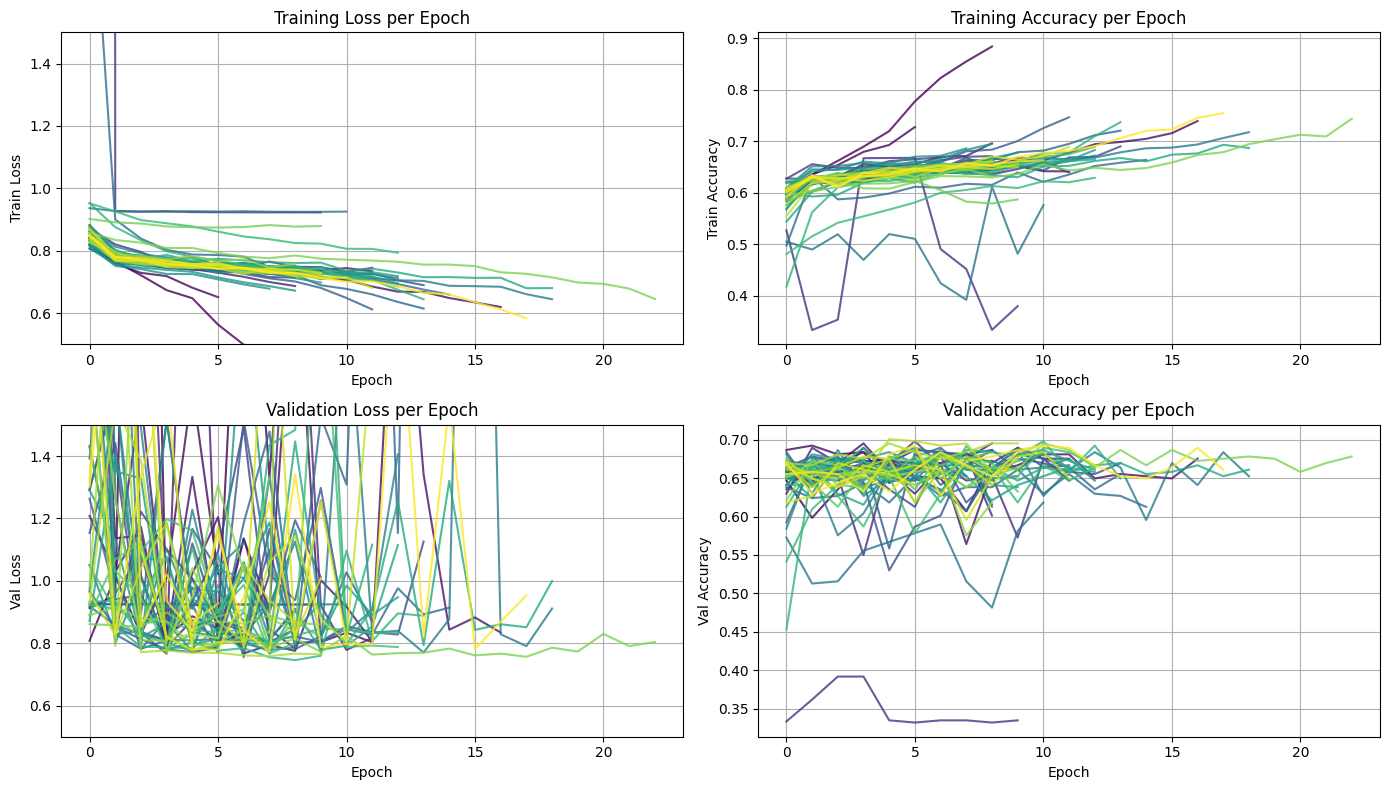

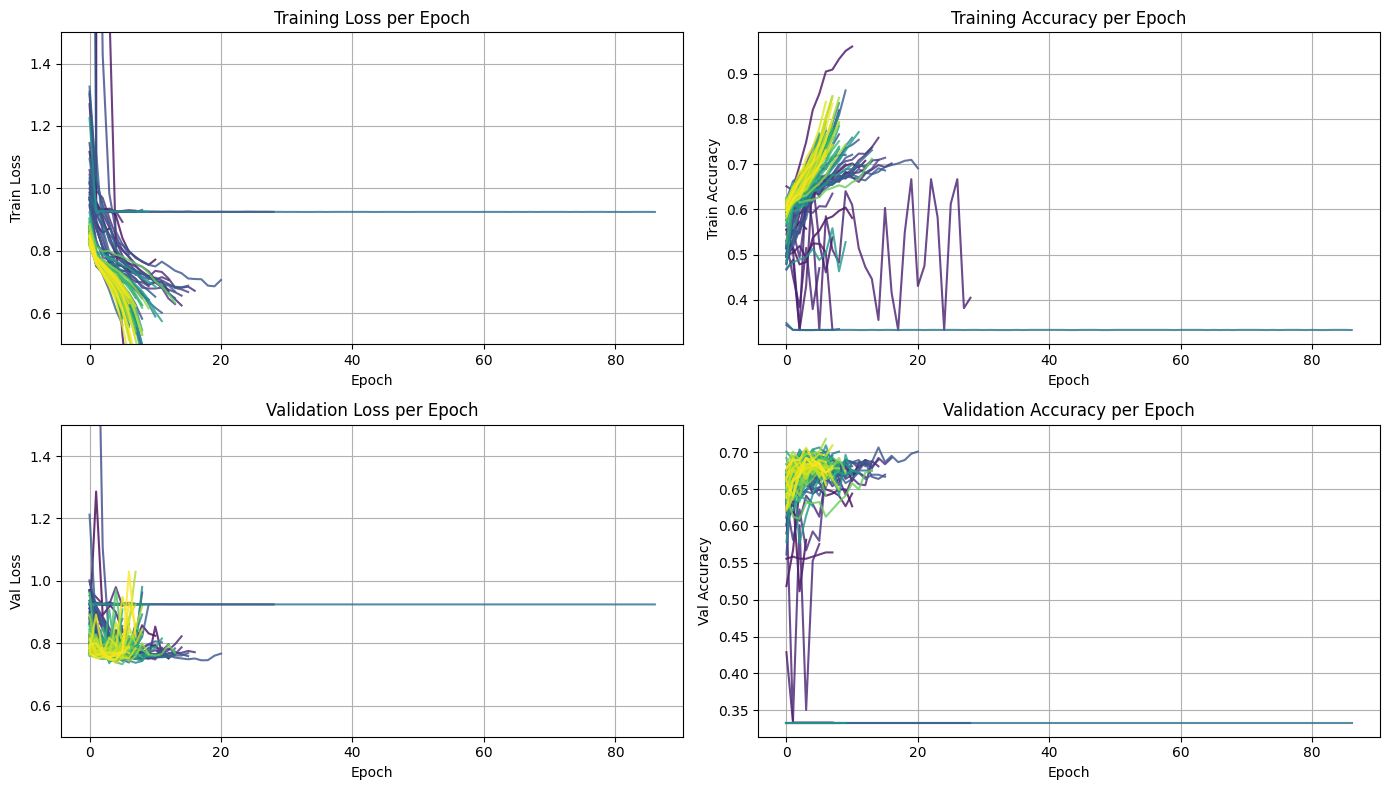

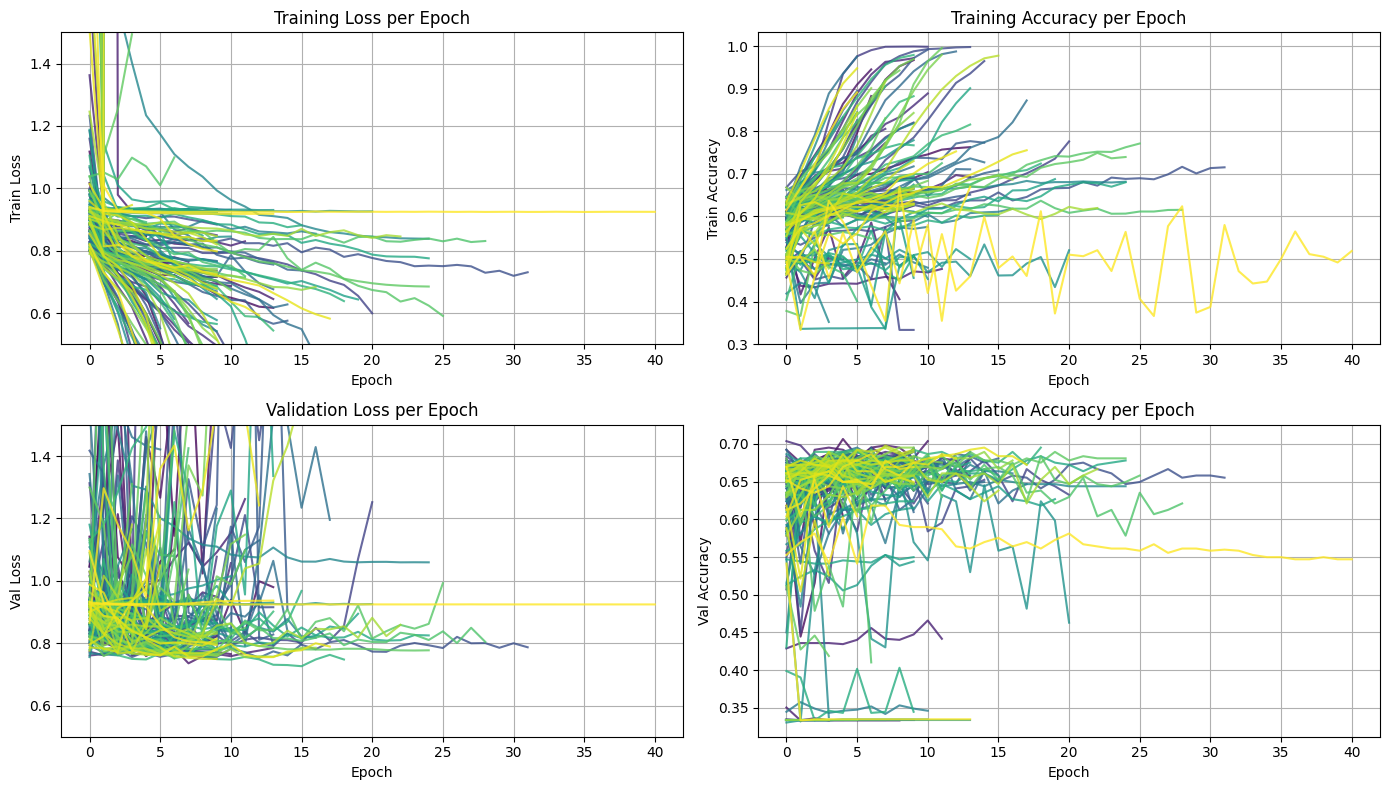

In [27]:
plot_all_epoch_curves("random_search")
plot_all_epoch_curves("ablation_search")
plot_all_epoch_curves("genetic_search")
plot_all_epoch_curves("bayesian_search")

# Final Test Evaluation

In [36]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy

def to_tensor_split(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    return X_tensor, y_tensor

X_test_t, y_test_t = to_tensor_split(X_test, y_test)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64)

def find_best_config_by_val_loss(base_dir):
    best_loss = float('inf')
    best_config_path = None

    for trial in os.listdir(base_dir):
        if not trial.startswith("trial_"):
            continue
        result_path = os.path.join(base_dir, trial, "results.json")
        if not os.path.exists(result_path):
            continue

        with open(result_path, "r") as f:
            results = json.load(f)
            val_losses = results.get("val_losses", [])
            if val_losses:
                final_loss = val_losses[-1]
                if final_loss < best_loss:
                    best_loss = final_loss
                    best_config_path = os.path.join(base_dir, trial, "config.json")

    return best_config_path, best_loss

def evaluate_on_test_set(model, test_loader):
    model.eval()
    device = next(model.parameters()).device
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))
    test_loss = 0.0
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            test_loss += criterion(output, yb).item() * xb.size(0)
            all_logits.append(output.cpu())
            all_labels.append(yb.cpu())

    logits = torch.cat(all_logits).squeeze()
    labels = torch.cat(all_labels).squeeze()
    N = logits.shape[0]

    k = int(N * (1 / 3))
    threshold = torch.topk(logits, k).values.min()
    preds = (logits >= threshold).float()

    acc = (preds == labels).float().mean().item()
    test_loss /= N
    return test_loss, acc

# Main logic for all 4 strategies
search_dirs = ["random_search", "ablation_search", "genetic_search", "bayesian_search"]

for strategy in search_dirs:
    print(f"\n=== {strategy.upper()} ===")
    config_path, best_val_loss = find_best_config_by_val_loss(strategy)
    
    if config_path is None:
        print("No valid result found.")
        continue

    with open(config_path, "r") as f:
        config = json.load(f)

    print(f"Best final val loss: {best_val_loss:.4f}")
    print("Best hyperparameters:")
    for k, v in config.items():
        print(f"{k}: {v}")

    # Re-train best model
    model, val_acc, total_time, *_ = train_model(**config)

    # Evaluate on test set
    test_loss, test_acc = evaluate_on_test_set(model, test_loader)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")



=== RANDOM_SEARCH ===
Best final val loss: 0.7532
Best hyperparameters:
conv_layers: 2
conv_kernel_size: 3
fc_layers: 5
fc_width: 256
normalization: Layernorm
activation: ReLU
dropout_rate: 0
lr: 0.001
weight_decay: 1e-05
batch_size: 256
t_max: 25
early_stop_patience: 3
batch type:  <class 'int'>
created model
created dataset splits
training
Epoch  1 | Train Loss: 0.9469 | Train Acc: 0.5258 | Val Loss: 0.9237 | Val Acc: 0.6809 | Pred_1: 33.33% | LR: 0.000996
Epoch  2 | Train Loss: 0.9252 | Train Acc: 0.5273 | Val Loss: 0.9263 | Val Acc: 0.6695 | Pred_1: 33.33% | LR: 0.000984
Epoch  3 | Train Loss: 0.9206 | Train Acc: 0.5063 | Val Loss: 0.9126 | Val Acc: 0.6553 | Pred_1: 33.33% | LR: 0.000965
Epoch  4 | Train Loss: 0.8539 | Train Acc: 0.6144 | Val Loss: 0.7841 | Val Acc: 0.6667 | Pred_1: 33.33% | LR: 0.000938
Epoch  5 | Train Loss: 0.7863 | Train Acc: 0.6184 | Val Loss: 0.7713 | Val Acc: 0.6553 | Pred_1: 33.33% | LR: 0.000905
Epoch  6 | Train Loss: 0.7668 | Train Acc: 0.6046 | Val Loss